In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import talib as ta
import datetime as dt
pd.set_option('display.max_rows', 16)

import statsmodels.api as sm

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

In [3]:
ta.__version__

'0.4.17'

# Data

In [4]:
START = '2007-01-01'
END = '2024-12-31'

In [5]:
index_info = DataAPI.SecIDGet(assetClass="IDX",pandas="1")

In [6]:
index_id = index_info[index_info['secShortName'].isin(['上证综指','深证综指','创业板指','沪深300','中证500','中证1000'])].drop_duplicates('secShortName').secID.values
index_df = DataAPI.MktIdxdGet(indexID=index_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','openIndex','highestIndex','lowestIndex','closeIndex','turnoverVol','turnoverValue','CHGPct'],pandas="1")

In [7]:
index_df

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,CHGPct
0,000001.ZICN,上证综指,2007-01-04,2728.1880,2847.6150,2684.8180,2715.7190,12015602100,8.394553e+10,0.015042
1,000001.ZICN,上证综指,2007-01-05,2668.5770,2685.8040,2617.0190,2641.3340,10615562500,7.012870e+10,-0.027391
2,000001.ZICN,上证综指,2007-01-08,2621.0680,2708.4440,2620.6250,2707.1990,10681324400,7.216588e+10,0.024936
3,000001.ZICN,上证综指,2007-01-09,2711.0490,2809.3940,2691.3600,2807.8040,11075126700,8.622197e+10,0.037162
4,000001.ZICN,上证综指,2007-01-10,2838.1130,2841.7410,2770.9880,2825.5760,11176936500,7.905066e+10,0.006330
5,000001.ZICN,上证综指,2007-01-11,2819.3670,2841.1800,2763.8860,2770.1100,12159871700,8.398673e+10,-0.019630
6,000001.ZICN,上证综指,2007-01-12,2745.3210,2782.0250,2652.5780,2668.1100,10730376800,7.343404e+10,-0.036822
7,000001.ZICN,上证综指,2007-01-15,2660.0700,2795.3310,2658.8790,2794.7010,9176156100,6.693948e+10,0.047446
...,...,...,...,...,...,...,...,...,...,...
24385,399106.ZICN,深证综指,2024-04-10,1746.8300,1746.8300,1708.0281,1720.2761,44329488741,4.652598e+11,-0.017432


In [8]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']
# ST
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

In [9]:
# %%time
# # About 8 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# field = ["secID","tradeDate",'preClosePrice',"closePrice",'openPrice','highestPrice','lowestPrice',"negMarketValue","turnoverValue",'turnoverRate']
# while begin_ <= 2024:
#     if begin_ == 2024:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

CPU times: user 1min 7s, sys: 15.9 s, total: 1min 22s
Wall time: 12min 28s


In [10]:
# %%time
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate=START,endDate=END,isOpen=1,
#                                            field=["secID","tradeDate",
#                                                   'preClosePrice',"closePrice",
#                                                   'openPrice','highestPrice','lowestPrice',
#                                                   "negMarketValue",
#                                                   "turnoverValue",'turnoverRate'],pandas="1")
# stk_df.to_pickle('./data/stk_df.pkl')
# Takes about 6 mins

In [11]:
stk_df = pd.read_pickle('./data/stk_df.pkl')

In [12]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12578740 entries, 0 to 12578739
Data columns (total 10 columns):
secID             object
tradeDate         object
preClosePrice     object
closePrice        object
openPrice         object
highestPrice      object
lowestPrice       object
negMarketValue    object
turnoverValue     object
turnoverRate      object
dtypes: object(10)
memory usage: 959.7+ MB


In [13]:
num_cols = ['preClosePrice','closePrice','openPrice','highestPrice','lowestPrice',
            'negMarketValue','turnoverValue','turnoverRate']

In [14]:
for col in num_cols:
    stk_df[col] = pd.to_numeric(stk_df[col])

In [15]:
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
stk_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_df.shape)
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
stk_df = stk_df[stk_df['STflg'].isna()].copy()
stk_df.drop('STflg',axis=1,inplace=True)
print(stk_df.shape)

(12578740, 10)
(12026765, 10)


不填充停牌值比较合理，因为技术分析只看量价，直接计算量价关系较为合适

## 沪深300

In [16]:
hs300_df = index_df[index_df['secShortName']=='沪深300'].reset_index(drop=True)
hs300_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
hs300_df['open_ret'] = hs300_df['openIndex']/hs300_df['openIndex'].shift()-1
hs300_df

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2139.4900,2054.2400,2067.0900,10671970700,8.238107e+10,0.012758,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2083.4000,2030.7600,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.7400,2071.7200,2131.5600,8476790900,6.630394e+10,0.028308,0.010165
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2201.3600,2128.0600,2200.0900,8157762900,6.545619e+10,0.032150,0.031607
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,2194.7700,2255.9700,8490497900,6.882262e+10,0.025399,0.034279
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2289.9500,2224.3700,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2249.5400,2159.7700,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.6800,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272
...,...,...,...,...,...,...,...,...,...,...,...
4196,000300.ZICN,沪深300,2024-04-10,3528.9679,3531.2295,3490.0525,3504.7086,12879027400,1.997548e+11,-0.008145,-0.001250


In [17]:
hs300_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4204 entries, 0 to 4203
Data columns (total 11 columns):
indexID          4204 non-null object
secShortName     4204 non-null object
tradeDate        4204 non-null object
openIndex        4204 non-null float64
highestIndex     4204 non-null float64
lowestIndex      4204 non-null float64
closeIndex       4204 non-null float64
turnoverVol      4204 non-null int64
turnoverValue    4204 non-null float64
close_ret        4204 non-null float64
open_ret         4203 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 361.4+ KB


In [18]:
hs300_df['close_ret_demean'] = hs300_df['close_ret'] - hs300_df['close_ret'].mean()
hs300_df['open_ret_demean'] = hs300_df['open_ret'] - hs300_df['open_ret'].mean()

In [19]:
(hs300_df['close_ret']- hs300_df['close_ret_demean']).describe()

count    4.204000e+03
mean     2.667286e-04
std      5.786718e-18
min      2.667286e-04
25%      2.667286e-04
50%      2.667286e-04
75%      2.667286e-04
max      2.667286e-04
dtype: float64

In [20]:
hs300_cols = hs300_df.columns

# Technical indicators

## Moving average

### MA30

In [21]:
ta.SMA?

Docstring:
SMA(real[, timeperiod=?])

Simple Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function


In [22]:
ta.SMA(hs300_df['closeIndex'], 5)

0              NaN
1              NaN
2              NaN
3              NaN
4       2145.51800
5       2178.42600
6       2198.60000
7       2229.75600
           ...    
4196    3544.61648
4197    3529.33024
4198    3510.93740
4199    3513.47104
4200    3508.99654
4201    3521.13542
4202    3534.24684
4203    3547.41144
Length: 4204, dtype: float64

In [23]:
hs300_df['closeIndex'].rolling(5).mean()

0              NaN
1              NaN
2              NaN
3              NaN
4       2145.51800
5       2178.42600
6       2198.60000
7       2229.75600
           ...    
4196    3544.61648
4197    3529.33024
4198    3510.93740
4199    3513.47104
4200    3508.99654
4201    3521.13542
4202    3534.24684
4203    3547.41144
Name: closeIndex, Length: 4204, dtype: float64

In [24]:
MA_df = hs300_df.copy()
MA_df['MA30'] = ta.SMA(MA_df['closeIndex'], 30)

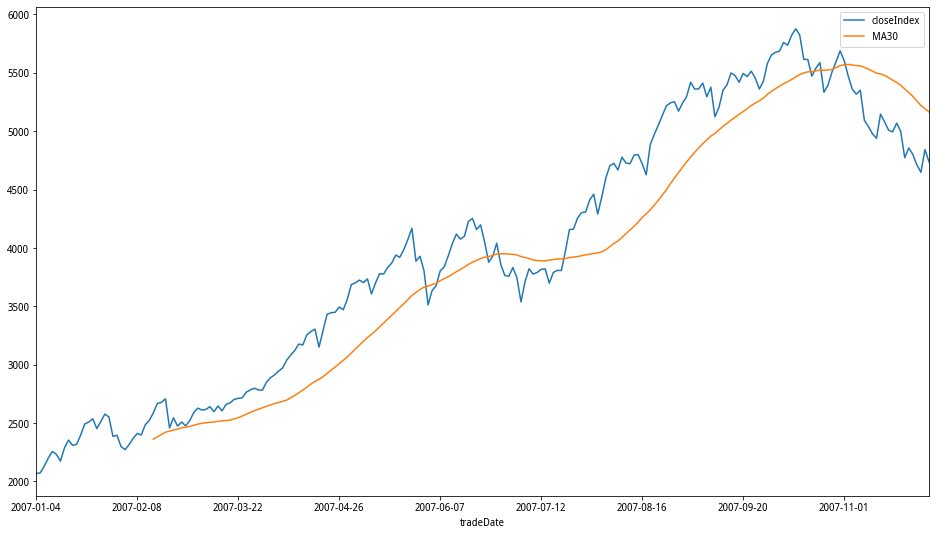

In [25]:
MA_df[['tradeDate','closeIndex','MA30']].set_index('tradeDate').loc[:'2007-12'].plot()

- 当收盘价高于均线时买入，低于均线时卖出

Case 1:
1. t日：收盘价高于MA30，假设可以以当日收盘价买入
2. t+k日：收盘价低于MA30，假设可以以当日收盘价卖出

Case 2:
1. t日：收盘价高于MA30，假设不能以当日收盘价买入。以次日开盘价买入
2. t+k日：收盘价低于MA30，假设不能以当日收盘价卖出。以次日开盘价卖出

In [26]:
MA_df['signal'] = np.nan
MA_df.loc[MA_df['closeIndex'] > MA_df['MA30'], 'signal'] = 1
MA_df.loc[MA_df['closeIndex'] < MA_df['MA30'], 'signal'] = 0

In [27]:
MA_df[~MA_df['signal'].isna()]

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean,MA30,signal
29,000300.ZICN,沪深300,2007-02-14,2527.5600,2594.6600,2520.5300,2588.3500,6277727900,5.846227e+10,0.026052,0.011692,0.025785,0.011405,2362.236000,1.0
30,000300.ZICN,沪深300,2007-02-15,2607.6300,2669.1800,2607.6300,2668.6300,7163132900,6.741569e+10,0.031016,0.031679,0.030749,0.031392,2382.287333,1.0
31,000300.ZICN,沪深300,2007-02-16,2692.6700,2717.5700,2660.4900,2676.7400,7590878500,7.159758e+10,0.003039,0.032612,0.002772,0.032325,2402.416000,1.0
32,000300.ZICN,沪深300,2007-02-26,2679.2700,2710.3000,2641.1200,2707.6800,7453156000,7.098161e+10,0.011559,-0.004976,0.011292,-0.005263,2421.620000,1.0
33,000300.ZICN,沪深300,2007-02-27,2717.8100,2719.5200,2454.9200,2457.4900,10773680700,1.011028e+11,-0.092400,0.014385,-0.092667,0.014098,2430.200000,1.0
34,000300.ZICN,沪深300,2007-02-28,2413.4200,2554.2300,2413.3300,2544.5700,8282257100,7.714825e+10,0.035435,-0.111998,0.035168,-0.112285,2439.820000,1.0
35,000300.ZICN,沪深300,2007-03-01,2550.2600,2550.3300,2439.5000,2473.5400,8215965500,7.429958e+10,-0.027914,0.056700,-0.028181,0.056413,2447.883667,1.0
36,000300.ZICN,沪深300,2007-03-02,2468.6700,2523.8600,2455.8200,2508.7300,5794680500,5.422210e+10,0.014227,-0.031993,0.013960,-0.032280,2459.049667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,000300.ZICN,沪深300,2024-04-10,3528.9679,3531.2295,3490.0525,3504.7086,12879027400,1.997548e+11,-0.008145,-0.001250,-0.008412,-0.001537,3548.814590,0.0


In [28]:
MA_df['position_close'] = MA_df['signal'] # 第一天收盘价生成signal后，立即对应于第一天收盘价形成的头寸
MA_df['position_open'] = MA_df['signal'].shift() # 第一天用收盘价生成signal。对应于第二天的开盘价形成的头寸

In [29]:
MA_df['position_close_ret'] = MA_df['position_close'].shift() * MA_df['close_ret']
MA_df['position_open_ret'] = MA_df['position_open'].shift() * MA_df['open_ret']
MA_df['position_close_ret_demean'] = MA_df['position_close'].shift() * MA_df['close_ret_demean']
MA_df['position_open_ret_demean'] = MA_df['position_open'].shift() * MA_df['open_ret_demean']

In [30]:
MA_df['MA30_close_cumret'] = (MA_df['position_close_ret']+1).cumprod()
MA_df['MA30_open_cumret'] = (MA_df['position_open_ret']+1).cumprod()

In [31]:
MA_df['signal'].unique()

array([nan,  1.,  0.])

In [32]:
MA_df[MA_df['signal']==0]

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,...,MA30,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
97,000300.ZICN,沪深300,2007-06-04,3804.9600,3822.4100,3503.9400,3511.4300,9053101900,1.312962e+11,-0.076899,...,3673.361667,0.0,0.0,1.0,-0.076899,-0.037474,-0.077166,-0.037761,1.356627,1.459164
98,000300.ZICN,沪深300,2007-06-05,3407.0000,3635.1500,3246.7300,3634.6300,11376803800,1.507649e+11,0.035085,...,3685.062667,0.0,0.0,0.0,0.000000,-0.104590,0.000000,-0.104876,1.356627,1.306550
99,000300.ZICN,沪深300,2007-06-06,3652.8900,3712.5300,3550.7400,3677.5800,9595151000,1.359385e+11,0.011817,...,3697.498667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.356627,1.306550
112,000300.ZICN,沪深300,2007-06-25,4066.4500,4105.9900,3850.8400,3877.5900,7003104400,1.134327e+11,-0.042908,...,3925.166667,0.0,0.0,1.0,-0.042908,-0.032519,-0.043175,-0.032805,1.383489,1.392962
113,000300.ZICN,沪深300,2007-06-26,3804.4100,3929.3700,3752.9300,3928.2100,5888511400,8.786774e+10,0.013055,...,3935.952333,0.0,0.0,0.0,0.000000,-0.064439,0.000000,-0.064726,1.383489,1.303200
115,000300.ZICN,沪深300,2007-06-28,4038.3800,4067.8100,3857.8500,3858.5200,6685798000,9.837205e+10,-0.045034,...,3949.955667,0.0,0.0,1.0,-0.045034,0.000000,-0.045301,0.000000,1.321185,1.303200
116,000300.ZICN,沪深300,2007-06-29,3769.3300,3867.7500,3718.1600,3764.0800,5892087000,8.852759e+10,-0.024476,...,3949.537333,0.0,0.0,0.0,-0.000000,-0.066623,-0.000000,-0.066910,1.321185,1.216377
117,000300.ZICN,沪深300,2007-07-02,3746.1800,3801.9000,3644.1900,3757.6600,4974731000,7.199587e+10,-0.001706,...,3947.078000,0.0,0.0,0.0,-0.000000,-0.000000,-0.000000,-0.000000,1.321185,1.216377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4194,000300.ZICN,沪深300,2024-04-08,3553.5554,3567.8200,3535.7688,3536.4077,15530428300,2.432493e+11,-0.008800,...,3545.644737,0.0,0.0,1.0,-0.008800,-0.007022,-0.009067,-0.007308,3.885789,2.280490


In [34]:
MA_df.loc[96:99]

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,...,MA30,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
96,000300.ZICN,沪深300,2007-06-01,3953.10,4014.15,3780.03,3803.95,11993793900,1.939803e+11,-0.031569,...,3664.847333,1.0,1.0,1.0,-0.031569,0.032432,-0.031836,0.032145,1.469641,1.515974
97,000300.ZICN,沪深300,2007-06-04,3804.96,3822.41,3503.94,3511.43,9053101900,1.312962e+11,-0.076899,...,3673.361667,0.0,0.0,1.0,-0.076899,-0.037474,-0.077166,-0.037761,1.356627,1.459164
98,000300.ZICN,沪深300,2007-06-05,3407.00,3635.15,3246.73,3634.63,11376803800,1.507649e+11,0.035085,...,3685.062667,0.0,0.0,0.0,0.000000,-0.104590,0.000000,-0.104876,1.356627,1.306550
99,000300.ZICN,沪深300,2007-06-06,3652.89,3712.53,3550.74,3677.58,9595151000,1.359385e+11,0.011817,...,3697.498667,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.356627,1.306550


In [35]:
3511.43/3803.95 - 1

-0.07689901286820278

In [36]:
3407.00 / 3804.96 - 1

-0.10458979857869732

In [37]:
## Example
temp = MA_df.loc[99:113,['tradeDate','openIndex','closeIndex','close_ret','open_ret','signal',
                        'position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean']].copy()
temp['MA30_close_cumret'] = (temp['position_close_ret']+1).cumprod()
temp['MA30_open_cumret'] = (temp['position_open_ret']+1).cumprod()

display(temp)

# close 
print(3877.59 / 3802.30)

# open
print(3804.41 / 3814.19)

,tradeDate,openIndex,closeIndex,close_ret,open_ret,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,MA30_close_cumret,MA30_open_cumret
99,2007-06-06,3652.89,3677.58,0.011817,0.072172,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
100,2007-06-07,3694.55,3802.30,0.033914,0.011405,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
101,2007-06-08,3814.19,3837.87,0.009355,0.032383,1.0,1.0,1.0,0.009355,0.000000,0.009088,0.000000,1.009355,1.000000
102,2007-06-11,3876.07,3931.86,0.024490,0.016224,1.0,1.0,1.0,0.024490,0.016224,0.024223,0.015937,1.034074,1.016224
103,2007-06-12,3953.96,4036.11,0.026514,0.020095,1.0,1.0,1.0,0.026514,0.020095,0.026247,0.019808,1.061492,1.036645
104,2007-06-13,4071.74,4118.27,0.020356,0.029788,1.0,1.0,1.0,0.020356,0.029788,0.020089,0.029501,1.083099,1.067524
105,2007-06-14,4103.52,4075.82,-0.010308,0.007805,1.0,1.0,1.0,-0.010308,0.007805,-0.010575,0.007518,1.071935,1.075856
106,2007-06-15,4043.11,4099.38,0.005780,-0.014722,1.0,1.0,1.0,0.005780,-0.014722,0.005513,-0.015008,1.078130,1.060018
107,2007-06-18,4178.76,4227.57,0.031271,0.033551,1.0,1.0,1.0,0.031271,0.033551,0.031004,0.033264,1.111845,1.095583
108,2007-06-19,4227.59,4253.00,0.006015,0.011685,1.0,1.0,1.0,0.006015,0.011685,0.005748,0.011399,1.118532,1.108385


1.0198011729742524
0.9974358907133625


In [38]:
MA30_ret_df = MA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','MA30',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean',
                        'MA30_close_cumret','MA30_open_cumret']].copy()

In [39]:
MA30_ret_df.set_index('tradeDate',inplace=True)

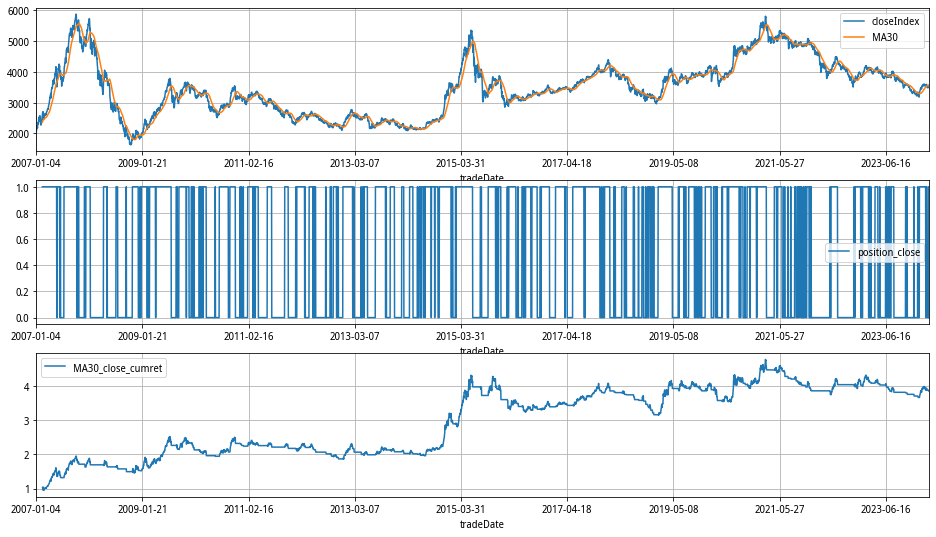

In [40]:
# Close price cumret
fig, axes = plt.subplots(3,1)
MA30_ret_df[['closeIndex','MA30']].plot(ax=axes[0],grid=True)
MA30_ret_df[['position_close']].plot(ax=axes[1],grid=True)
MA30_ret_df[['MA30_close_cumret']].plot(ax=axes[2],grid=True)

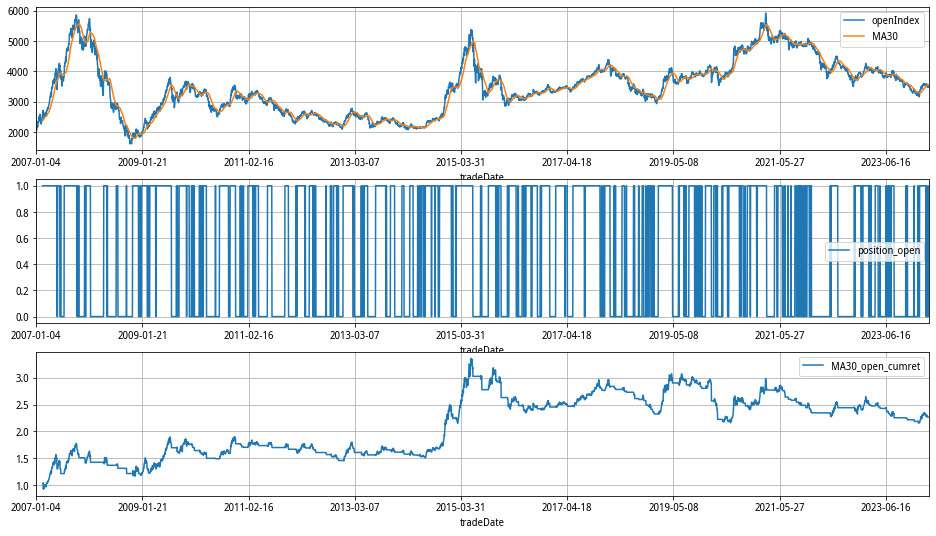

In [41]:
# open price cumret
fig, axes = plt.subplots(3,1)
MA30_ret_df[['openIndex','MA30']].plot(ax=axes[0],grid=True)
MA30_ret_df[['position_open']].plot(ax=axes[1], grid=True)
MA30_ret_df[['MA30_open_cumret']].plot(ax=axes[2], grid=True)

### MA20

In [42]:
hs300_df

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2139.4900,2054.2400,2067.0900,10671970700,8.238107e+10,0.012758,NaN,0.012491,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2083.4000,2030.7600,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660,0.002534,-0.010946
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.7400,2071.7200,2131.5600,8476790900,6.630394e+10,0.028308,0.010165,0.028041,0.009878
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2201.3600,2128.0600,2200.0900,8157762900,6.545619e+10,0.032150,0.031607,0.031883,0.031320
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,2194.7700,2255.9700,8490497900,6.882262e+10,0.025399,0.034279,0.025132,0.033992
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2289.9500,2224.3700,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920,-0.011056,0.020634
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2249.5400,2159.7700,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232,-0.026203,-0.018519
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.6800,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272,0.051988,-0.020559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,000300.ZICN,沪深300,2024-04-10,3528.9679,3531.2295,3490.0525,3504.7086,12879027400,1.997548e+11,-0.008145,-0.001250,-0.008412,-0.001537


In [43]:
MA_df = hs300_df.copy()

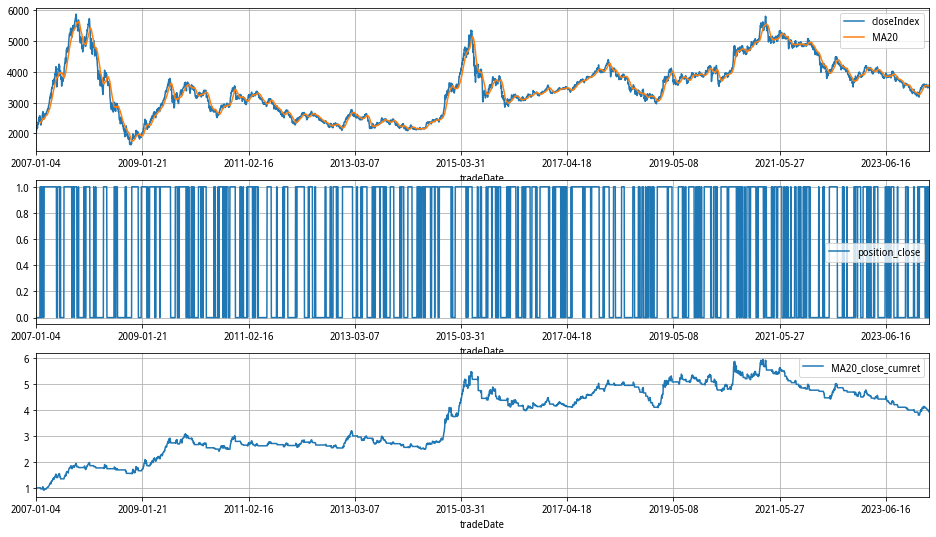

In [44]:
ma_length = 20

MA_df[f'MA{ma_length}'] = ta.SMA(MA_df['closeIndex'], ma_length)
MA_df['signal'] = 0
ndays = MA_df.shape[0]
MA_df.loc[MA_df['closeIndex'] > MA_df[f'MA{ma_length}'], 'signal'] = 1
MA_df['open_ret'] = MA_df['openIndex']/MA_df['openIndex'].shift()-1
MA_df['position_close'] = MA_df['signal']
MA_df['position_open'] = MA_df['signal'].shift()
MA_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
MA_df['position_close'] = MA_df['signal']
MA_df['position_close_ret'] = MA_df['position_close'].shift() * MA_df['close_ret']
MA_df['position_open_ret'] = MA_df['position_open'].shift() * MA_df['open_ret']
MA_df['position_close_ret_demean'] = MA_df['position_close'].shift() * MA_df['close_ret_demean']
MA_df['position_open_ret_demean'] = MA_df['position_open'].shift() * MA_df['open_ret_demean']

MA_df[f'MA{ma_length}_close_cumret'] = (MA_df['position_close_ret']+1).cumprod()
MA_df[f'MA{ma_length}_open_cumret'] = (MA_df['position_open_ret']+1).cumprod()
MA_ret_df = MA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret',f'MA{ma_length}',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                        'position_close_ret_demean','position_open_ret_demean',
                        f'MA{ma_length}_close_cumret',f'MA{ma_length}_open_cumret']].copy()
MA_ret_df.set_index('tradeDate',inplace=True)
# Close price cumret
fig, axes = plt.subplots(3,1)
MA_ret_df[['closeIndex',f'MA{ma_length}']].plot(ax=axes[0],grid=True)
MA_ret_df[['position_close']].plot(ax=axes[1],grid=True)
MA_ret_df[[f'MA{ma_length}_close_cumret']].plot(ax=axes[2],grid=True)

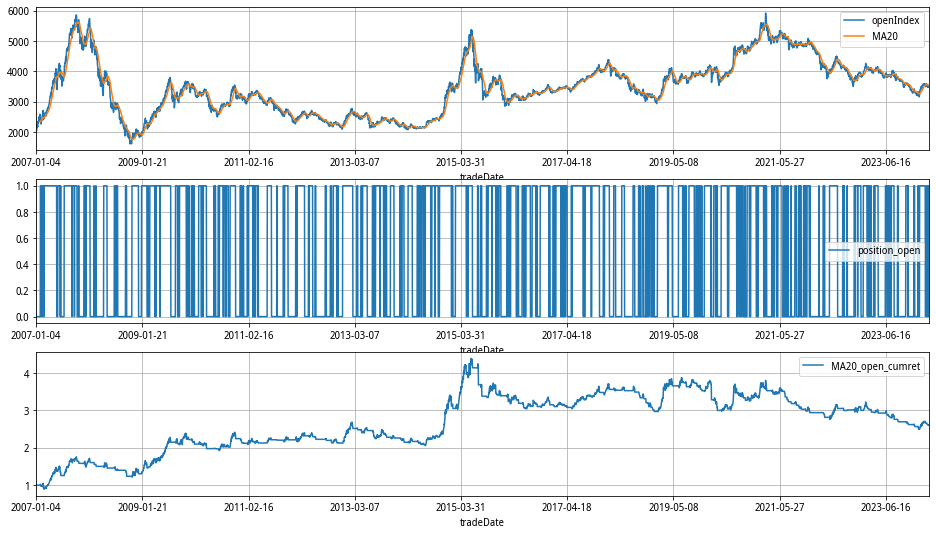

In [45]:
# open price cumret
fig, axes = plt.subplots(3,1)
MA_ret_df[['openIndex',f'MA{ma_length}']].plot(ax=axes[0],grid=True)
MA_ret_df[['position_open']].plot(ax=axes[1],grid=True)
MA_ret_df[[f'MA{ma_length}_open_cumret']].plot(ax=axes[2],grid=True)

## Exponential moving average

In [46]:
ta.EMA?

Docstring:
EMA(real[, timeperiod=?])

Exponential Moving Average (Overlap Studies)

Inputs:
    real: (any ndarray)
Parameters:
    timeperiod: 30
Outputs:
    real
Type:      function


\begin{aligned}
E M A_{\text {Today }}=&\left(\text { Value }_{\text {Today }} *\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) \\
&+E M A_{\text {Yesterday }} *\left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)
\end{aligned}

Smoothing = 2

### EMA20

In [47]:
ema_length = 20
EMA_df = hs300_df.copy()
EMA_df['EMA'] = ta.EMA(EMA_df['closeIndex'], ema_length)

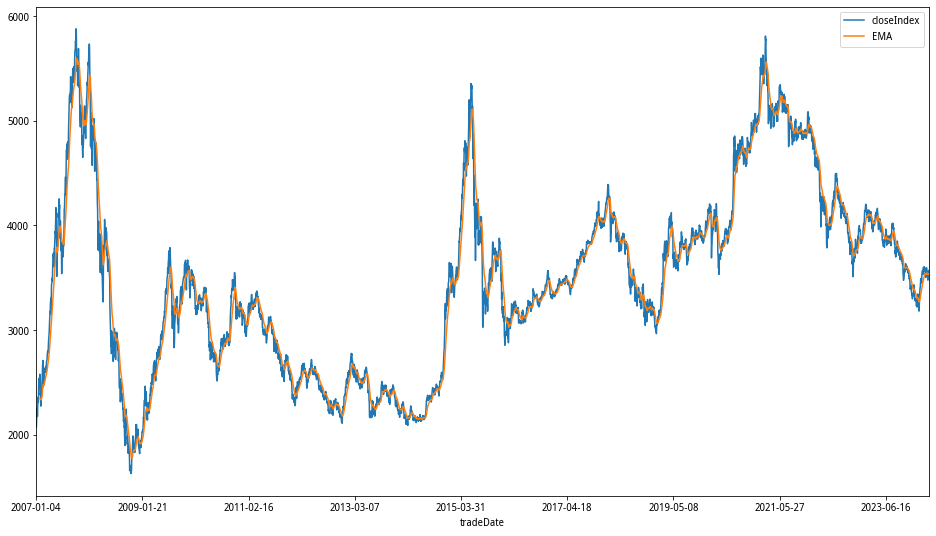

In [48]:
EMA_df[['tradeDate','closeIndex','EMA']].set_index('tradeDate').plot()

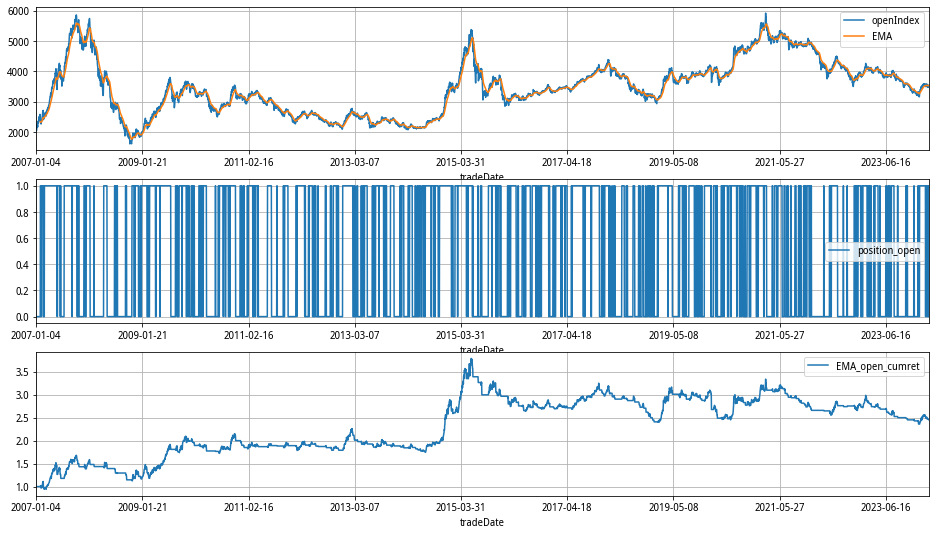

In [49]:
EMA_df['EMA'] = ta.EMA(EMA_df['closeIndex'], ema_length)
EMA_df['signal'] = 0
EMA_df.loc[EMA_df['closeIndex'] > EMA_df['EMA'], 'signal'] = 1
EMA_df['open_ret'] = EMA_df['openIndex']/EMA_df['openIndex'].shift()-1
EMA_df['position_close'] = EMA_df['signal']
EMA_df['position_open'] = EMA_df['signal'].shift()
EMA_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
EMA_df['position_close_ret'] = EMA_df['position_close'].shift() * EMA_df['close_ret']
EMA_df['position_open_ret'] = EMA_df['position_open'].shift() * EMA_df['open_ret']
EMA_df['position_close_ret_demean'] = EMA_df['position_close'].shift() * EMA_df['close_ret_demean']
EMA_df['position_open_ret_demean'] = EMA_df['position_open'].shift() * EMA_df['open_ret_demean']
EMA_df['EMA_close_cumret'] = (EMA_df['position_close_ret']+1).cumprod()
EMA_df['EMA_open_cumret'] = (EMA_df['position_open_ret']+1).cumprod()
EMA_ret_df = EMA_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','EMA',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                       'position_close_ret_demean','position_open_ret_demean',
                        'EMA_close_cumret','EMA_open_cumret']].copy()
EMA_ret_df.set_index('tradeDate',inplace=True)
# open price cumret
fig, axes = plt.subplots(3,1)
EMA_ret_df[['openIndex','EMA']].plot(ax=axes[0], grid=True)
EMA_ret_df[['position_open']].plot(ax=axes[1], grid=True)
EMA_ret_df[['EMA_open_cumret']].plot(ax=axes[2], grid=True)

In [50]:
EMA_ret_df

,openIndex,closeIndex,open_ret,close_ret,EMA,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,EMA_close_cumret,EMA_open_cumret
tradeDate,,,,,,,,,,,,,,
2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,NaN,0,0,0.0,0.000000,NaN,0.000000,NaN,1.000000,NaN
2007-01-08,2072.0000,2131.5600,0.010165,0.028308,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2007-01-09,2137.4900,2200.0900,0.031607,0.032150,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2007-01-10,2210.7600,2255.9700,0.034279,0.025399,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,NaN,0,0,0.0,-0.000000,0.000000,-0.000000,0.000000,1.000000,1.000000
2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,NaN,0,0,0.0,-0.000000,-0.000000,-0.000000,-0.000000,1.000000,1.000000
2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,NaN,0,0,0.0,0.000000,-0.000000,0.000000,-0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


# Statistical Inferences

## Cross-sectional test

In [51]:
def rule_return(df, demean=True, open_ret=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['close_ret_demean'] = df['close_ret'] - df['close_ret'].mean()
    df['open_ret_demean'] = df['open_ret'] - df['open_ret'].mean()
    df['position_close'] = df['signal']
    df['position_open'] = df['signal'].shift()
    df['position_close_ret'] = df['position_close'].shift() * df['close_ret']
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_close_ret_demean'] = df['position_close'].shift() * df['close_ret_demean']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    df['close_cumret'] = (df['position_close_ret']+1).cumprod()
    df['open_cumret'] = (df['position_open_ret']+1).cumprod()
    if open_ret:
        if demean:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_open_ret_demean':df['position_open_ret_demean'].values, 
                                 'open_cumret':df['open_cumret'].values})
        else:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_open_ret':df['position_open_ret'].values, 
                                 'open_cumret':df['open_cumret'].values})
    else:
        if demean:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_close_ret_demean':df['position_close_ret_demean'].values, 
                                 'close_cumret':df['close_cumret'].values})
        else:
            return pd.DataFrame({'tradeDate':df['tradeDate'].values,
                                 'position_close_ret':df['position_close_ret'].values, 
                                 'close_cumret':df['close_cumret'].values})

In [52]:
ema_length = 20

In [53]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,1053.778,970.235,4.835036e+10,4.182345e+09,0.0840
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,1085.740,988.906,5.318694e+10,2.285485e+09,0.0440
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,1132.891,1069.601,5.487665e+10,2.761567e+09,0.0510
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,1157.574,1087.005,5.456661e+10,2.324186e+09,0.0426
113,000001.XSHE,2007-06-26,1113.904,1113.904,0.000,0.000,0.000,5.456661e+10,0.000000e+00,0.0000
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,1069.284,1002.513,4.994705e+10,2.446556e+09,0.0489
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,1024.348,950.299,4.672266e+10,1.617434e+09,0.0336
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,948.717,861.377,4.266117e+10,1.410758e+09,0.0316
...,...,...,...,...,...,...,...,...,...,...
12578732,689009.XSHG,2024-04-10,28.070,27.570,28.180,28.180,27.150,1.421167e+10,1.128337e+08,0.0080


In [54]:
stk_df['EMA'] = stk_df.groupby('secID')['closePrice'].apply(ta.EMA, 20)

In [55]:
stk_df.drop(stk_df.loc[stk_df['openPrice']==0].index, inplace=True) # drop 停牌但有收盘价的数据

In [56]:
stk_df.loc[stk_df['openPrice']==0]

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,EMA


In [57]:
stk_df['open_ret'] = stk_df.groupby('secID')['openPrice'].apply(lambda x: x / x.shift() - 1)

In [58]:
stk_df['close_ret'] = stk_df['closePrice']/stk_df['preClosePrice'] - 1


In [59]:
stk_df['signal'] = 0
stk_df.loc[stk_df['closePrice'] > stk_df['EMA'], 'signal'] = 1

In [60]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,1053.778,970.235,4.835036e+10,4.182345e+09,0.0840,NaN,NaN,0.197544,0
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,1085.740,988.906,5.318694e+10,2.285485e+09,0.0440,NaN,-0.016970,0.100033,0
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,1132.891,1069.601,5.487665e+10,2.761567e+09,0.0510,NaN,0.097410,0.031769,0
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,1157.574,1087.005,5.456661e+10,2.324186e+09,0.0426,NaN,0.011516,-0.005650,0
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,1069.284,1002.513,4.994705e+10,2.446556e+09,0.0489,NaN,-0.120245,-0.084659,0
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,1024.348,950.299,4.672266e+10,1.617434e+09,0.0336,NaN,-0.005682,-0.064557,0
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,948.717,861.377,4.266117e+10,1.410758e+09,0.0316,NaN,-0.053968,-0.086928,0
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,881.629,840.807,4.247515e+10,8.756147e+08,0.0209,NaN,-0.100336,-0.004360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12578732,689009.XSHG,2024-04-10,28.070,27.570,28.180,28.180,27.150,1.421167e+10,1.128337e+08,0.0080,29.920663,0.026594,-0.017813,0


In [61]:
%%time
rule_ret_df = stk_df.groupby('secID').apply(rule_return)

CPU times: user 45.1 s, sys: 1.19 s, total: 46.3 s
Wall time: 46.2 s


In [62]:
rule_ret_df.reset_index(inplace=True)

In [63]:
rule_ret_df.drop('level_1',axis=1,inplace=True)

In [64]:
rule_ret_df

,secID,tradeDate,position_open_ret_demean,open_cumret
0,000001.XSHE,2007-06-20,NaN,NaN
1,000001.XSHE,2007-06-21,NaN,NaN
2,000001.XSHE,2007-06-22,0.000000,1.000000
3,000001.XSHE,2007-06-25,0.000000,1.000000
4,000001.XSHE,2007-06-27,-0.000000,1.000000
5,000001.XSHE,2007-06-28,-0.000000,1.000000
6,000001.XSHE,2007-06-29,-0.000000,1.000000
7,000001.XSHE,2007-07-02,-0.000000,1.000000
...,...,...,...,...
11647107,689009.XSHG,2024-04-10,0.000000,0.744692


### Cross-sectional test of cumulative return

In [65]:
rule_cumret_by_crs = rule_ret_df.groupby('secID')['open_cumret'].last()

In [66]:
rule_cumret_by_crs.describe()

count    5299.000000
mean        1.868915
std         3.024204
min         0.047341
25%         0.590588
50%         0.918365
75%         1.883555
max        48.810226
Name: open_cumret, dtype: float64

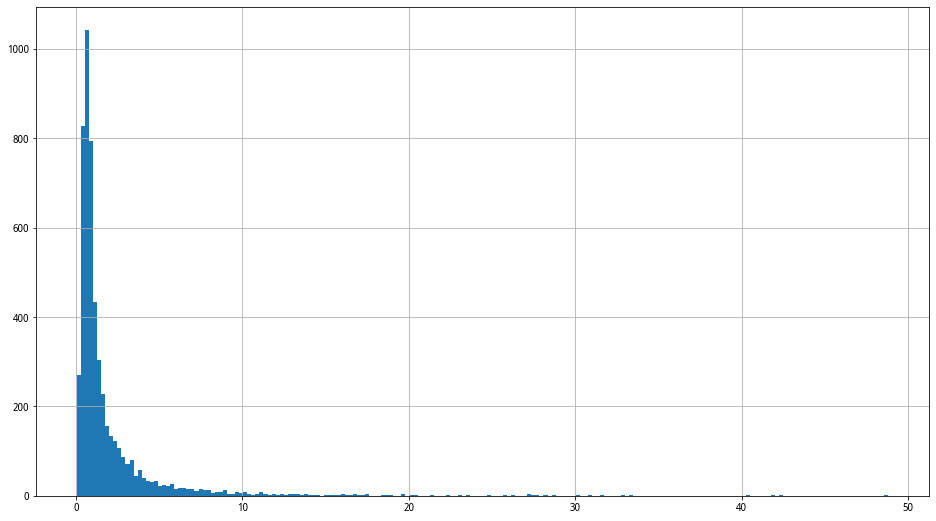

In [67]:
rule_cumret_by_crs.hist(bins=200)

In [68]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

,rule_cumret
ret_mean,0.868915
t_values,20.917230


In [69]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit()
print(reg.t_test('const = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.8689      0.042     20.915      0.000       1.787       1.950


平均年化收益：

In [70]:
# # 1.12/(2022-2007+1)
# 2.12**(1/(2022-2007+1)) - 1

0.048083759133757065

In [71]:
1.8689**(1/(2023-2007+1)) - 1

0.037470247331664375

这个统计检验不够好：
- 累积收益率可能在区间最后一段短时间内冲高
- 累积收益率右侧可以无限大，左侧有界(0)。日收益率原则上也是这样，但没有累积收益率这么严重

### Cross-sectional test of mean daily return

In [72]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = rule_ret_df.groupby('secID')['position_open_ret_demean'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE    0.000124
000002.XSHE    0.000011
000004.XSHE   -0.000072
000005.XSHE    0.000357
000006.XSHE    0.000327
000007.XSHE    0.000228
000008.XSHE    0.000462
000009.XSHE    0.000250
                 ...   
688789.XSHG   -0.001377
688793.XSHG   -0.000856
688798.XSHG    0.000238
688799.XSHG    0.000143
688800.XSHG   -0.000342
688819.XSHG    0.000444
688981.XSHG   -0.000167
689009.XSHG   -0.000264
Name: position_open_ret_demean, Length: 5299, dtype: float64

In [73]:
temp = stk_df[stk_df['secID']==np.random.choice(stk_df['secID'].unique(),1)[0]].copy()
temp['signal'] = 0
temp.loc[temp['closePrice'] > temp['EMA'], 'signal'] = 1
display(temp)
rule_return(temp)['position_open_ret_demean'].mean()

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
12377258,688278.XSHG,2020-01-17,8.240,35.300,30.530,36.500,28.750,1.348640e+09,921926523.0,0.7820,NaN,NaN,3.283981,0
12377259,688278.XSHG,2020-01-20,35.300,42.850,32.500,48.440,31.990,1.637089e+09,940436017.0,0.6350,NaN,0.064527,0.213881,0
12377260,688278.XSHG,2020-01-21,42.850,49.400,44.000,51.000,43.100,1.887332e+09,882266139.0,0.4825,NaN,0.353846,0.152859,0
12377261,688278.XSHG,2020-01-22,49.400,43.150,49.990,49.990,40.010,1.648550e+09,529235944.0,0.3078,NaN,0.136136,-0.126518,0
12377262,688278.XSHG,2020-01-23,43.150,42.160,44.990,47.080,40.030,1.610727e+09,361365562.0,0.2164,NaN,-0.100020,-0.022943,0
12377263,688278.XSHG,2020-02-03,42.160,49.080,36.300,49.940,36.300,1.875106e+09,661125746.0,0.3911,NaN,-0.193154,0.164137,0
12377264,688278.XSHG,2020-02-04,49.080,47.800,45.010,52.990,42.000,1.826204e+09,662493998.0,0.3622,NaN,0.239945,-0.026080,0
12377265,688278.XSHG,2020-02-05,47.800,49.230,46.530,51.290,46.030,1.880837e+09,568072949.0,0.3047,NaN,0.033770,0.029916,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12378280,688278.XSHG,2024-04-10,65.935,63.033,65.743,65.905,62.578,2.535584e+10,163892259.0,0.0064,64.397075,0.031910,-0.044013,0


0.0005565524286638859

In [74]:
rule_tsmean_ret_by_crs['002976.XSHE']

-0.0008695310486886148

In [75]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [76]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

,rule_daily_ret
ret_mean,-0.000110
t_values,-14.007997


## Time series test. Bootstrapping: White's Reality Check

- 原始index return去掉均值的目的：过滤掉牛市或者熊市时，随机策略的正或负的收益的偏误
- position return 去掉均值的目的：bootstrap 的原假设是：策略期望收益是0。以此生成抽样分布。

In [77]:
EMA_ret_df

,openIndex,closeIndex,open_ret,close_ret,EMA,signal,position_close,position_open,position_close_ret,position_open_ret,position_close_ret_demean,position_open_ret_demean,EMA_close_cumret,EMA_open_cumret
tradeDate,,,,,,,,,,,,,,
2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,NaN,0,0,0.0,0.000000,NaN,0.000000,NaN,1.000000,NaN
2007-01-08,2072.0000,2131.5600,0.010165,0.028308,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2007-01-09,2137.4900,2200.0900,0.031607,0.032150,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2007-01-10,2210.7600,2255.9700,0.034279,0.025399,NaN,0,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,NaN,0,0,0.0,-0.000000,0.000000,-0.000000,0.000000,1.000000,1.000000
2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,NaN,0,0,0.0,-0.000000,-0.000000,-0.000000,-0.000000,1.000000,1.000000
2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,NaN,0,0,0.0,0.000000,-0.000000,0.000000,-0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [78]:
rule_ret_series = EMA_ret_df['position_open_ret_demean'].dropna() # position_open_ret_demean: (raw return demeaned)*position
rule_ret_series_for_bootstrap = rule_ret_series - rule_ret_series.mean() # demean here: H0: the average of the rule's return is zero
n_sample = rule_ret_series.shape[0]
n_boostrap = 1000

In [79]:
n_sample

4202

In [80]:
rule_ret_series.mean()

0.00013157427473675618

In [81]:
rule_ret_mean_distr = []
for i in range(n_boostrap):
    rule_ret_mean_distr.append(np.random.choice(rule_ret_series_for_bootstrap, n_sample).mean())

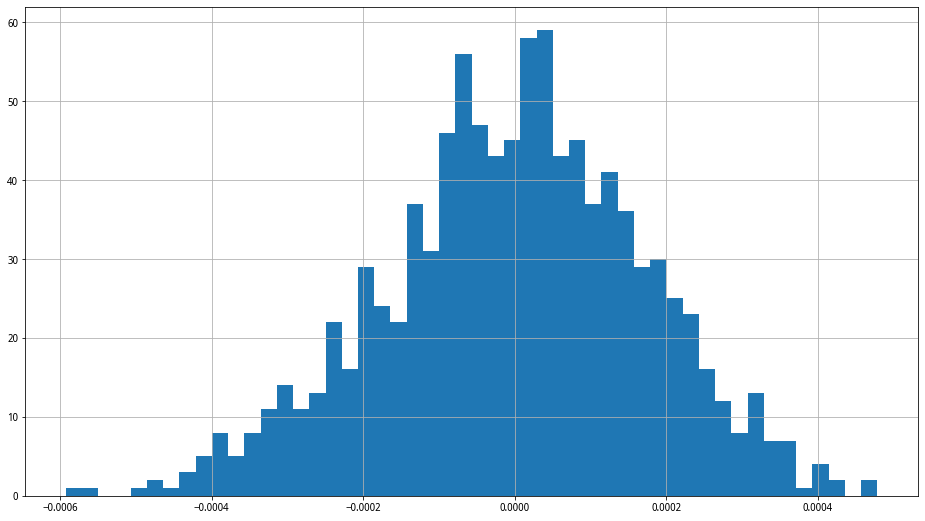

In [82]:
rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
rule_ret_mean_distr.hist(bins=50)

In [83]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum()

231

In [84]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum() / n_boostrap

0.231

In [85]:
np.mean(rule_ret_series)

0.00013157427473675618

In [86]:
def white_reality_test(rule_ret, n_boostrap=1000):
    n_sample = len(rule_ret)
    if n_sample < 100:
        return None
    else:
        mean_rule_ret = np.mean(rule_ret)
        rule_ret_for_bootstrap = rule_ret - mean_rule_ret
        rule_ret_mean_distr = []
        for i in range(n_boostrap):
            rule_ret_mean_distr.append(np.random.choice(rule_ret_for_bootstrap, n_sample).mean())
        rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
        pvalue = (rule_ret_mean_distr > mean_rule_ret).sum() / n_boostrap
        return pvalue

In [89]:
# The p value of the rule's return series
white_reality_test(rule_ret_series)

0.219

#### Test another stock

In [90]:
one_stk_id = np.random.choice(rule_ret_df['secID'].unique(),1)[0]

In [91]:
rule_ret_series = rule_ret_df.loc[rule_ret_df['secID'] == one_stk_id,'position_open_ret_demean']

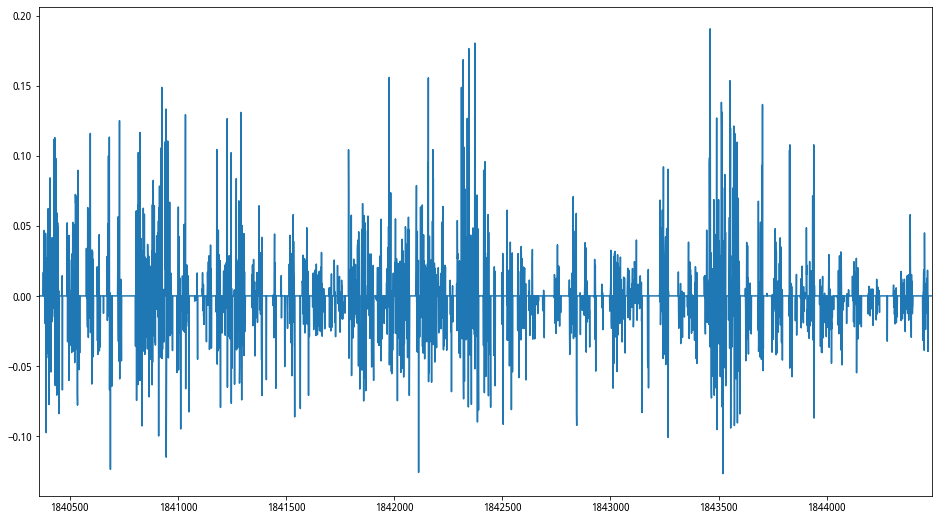

In [92]:
rule_ret_series.plot()

In [93]:
rule_ret_series.dropna(inplace=True)

In [94]:
white_reality_test(rule_ret_series)

0.281

#### Test 300 stocks

In [95]:
stk_id_300 = np.random.choice(rule_ret_df['secID'].unique(),300,replace=False)

In [96]:
temp = rule_ret_df.loc[rule_ret_df['secID'].isin(stk_id_300)].copy()

In [97]:
temp.dropna(inplace=True)

In [98]:
temp

,secID,tradeDate,position_open_ret_demean,open_cumret
25651,000010.XSHE,2013-10-22,0.000000,1.000000
25652,000010.XSHE,2013-10-23,0.000000,1.000000
25653,000010.XSHE,2013-10-24,-0.000000,1.000000
25654,000010.XSHE,2013-10-25,0.000000,1.000000
25655,000010.XSHE,2013-10-28,-0.000000,1.000000
25656,000010.XSHE,2013-10-29,-0.000000,1.000000
25657,000010.XSHE,2013-10-30,-0.000000,1.000000
25658,000010.XSHE,2013-10-31,0.000000,1.000000
...,...,...,...,...
11608388,688661.XSHG,2024-04-10,0.000000,0.928323


In [99]:
%%time
stk_white_p = temp.groupby('secID')['position_open_ret_demean'].apply(white_reality_test)

CPU times: user 36.4 s, sys: 0 ns, total: 36.4 s
Wall time: 36.4 s


In [100]:
stk_white_p

secID
000010.XSHE    0.559
000040.XSHE    0.113
000046.XSHE    0.124
000070.XSHE    0.373
000400.XSHE    0.669
000418.XSHE    0.416
000567.XSHE    0.434
000581.XSHE    0.577
               ...  
688556.XSHG    0.325
688603.XSHG    0.356
688626.XSHG    0.434
688636.XSHG    0.228
688648.XSHG    0.627
688655.XSHG    0.209
688657.XSHG    0.749
688661.XSHG    0.588
Name: position_open_ret_demean, Length: 300, dtype: float64

In [101]:
stk_white_p.describe()

count    298.000000
mean       0.529829
std        0.247319
min        0.007000
25%        0.333000
50%        0.522500
75%        0.729000
max        0.998000
Name: position_open_ret_demean, dtype: float64

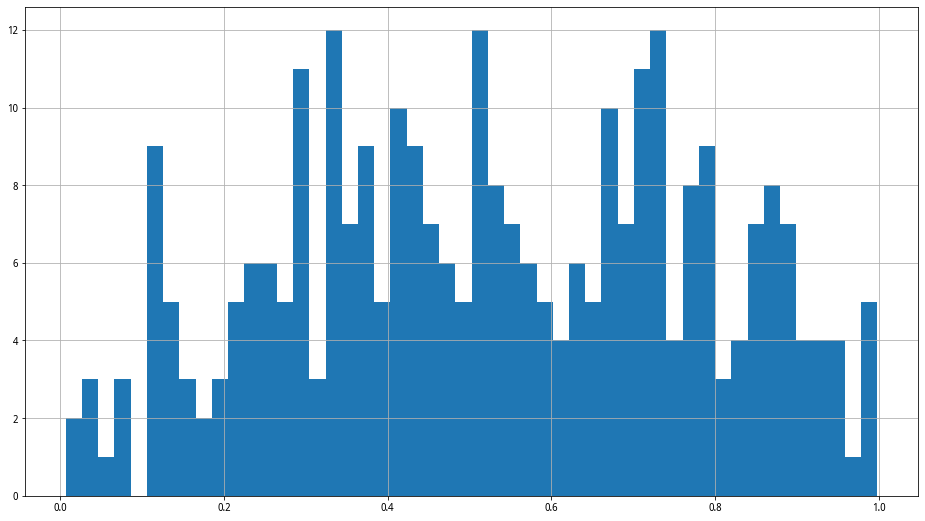

In [102]:
stk_white_p.hist(bins=50)

In [103]:
stk_white_p.loc[stk_white_p < 0.10]

secID
000673.XSHE    0.022
000800.XSHE    0.066
002246.XSHE    0.071
002509.XSHE    0.078
002604.XSHE    0.027
002647.XSHE    0.071
600146.XSHG    0.007
600991.XSHG    0.044
603555.XSHG    0.039
Name: position_open_ret_demean, dtype: float64

In [104]:
good_EMA_stks = stk_white_p.loc[stk_white_p < 0.10].index

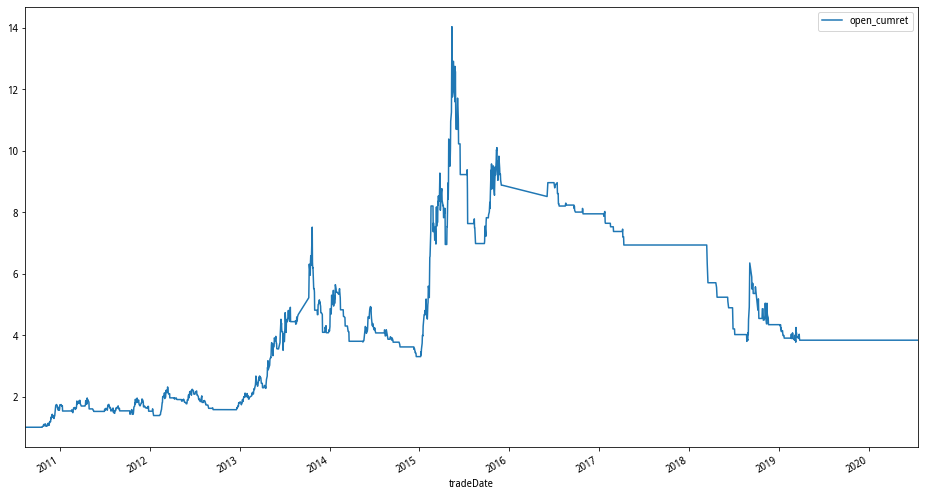

In [105]:
rule_ret_df.loc[rule_ret_df['secID']=='300104.XSHE',['tradeDate','open_cumret']].set_index('tradeDate').plot()

In [106]:
rule_ret_df.loc[rule_ret_df['secID'].isin(good_EMA_stks[0:5])].set_index('tradeDate',inplace=True)

In [107]:
temp2 = rule_ret_df.loc[rule_ret_df['secID'].isin(good_EMA_stks)].copy()

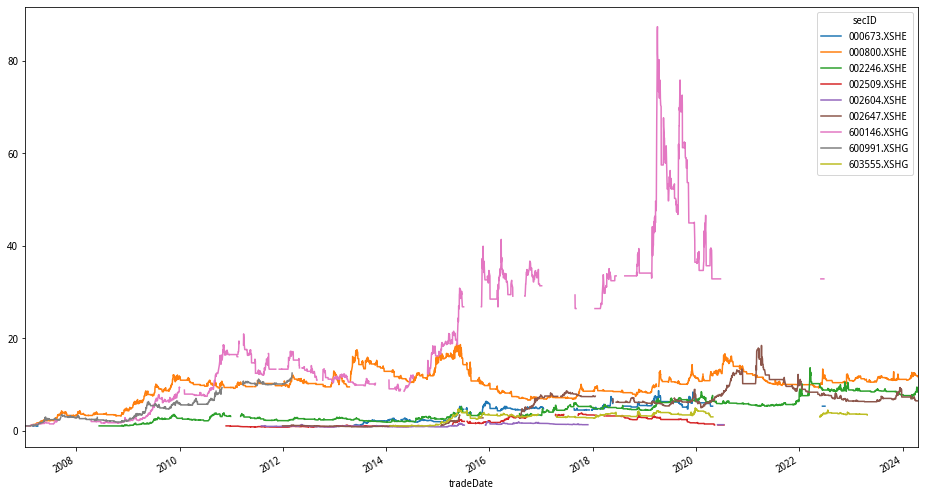

In [108]:
temp2.pivot(index='tradeDate',columns='secID',values='open_cumret').plot()

# MACD

Moving Average Convergence Divergence (MACD)

$$MACD = EMA_{\text{fast period}} - EMA_{\text{slow period}}$$

$$E M A_t(\text{Value})= \left(\text { Value }_t *\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right) + E M A_{t-1} *\left(1-\left(\frac{\text { Smoothing }}{1+\text { Days }}\right)\right)$$

$Smoothing = 2$, $\text{fast period} = 12$, $\text{slow period} = 26$. 第一个$EMA$用简单平均。比如，计算$EMA_{\text{12 period}}$，那么就等有12个观测值之后，取简单平均得到$EMA_1$，然后$EMA_2$用上述公式计算。

按照级数展开可发现，越靠近当前的价格，权重越大。Smoothing越大，越靠近当前价格的权重越大。

得到 MACD 以后，再计算 MACD 的 Signal，

$$Signal = EMA_{\text{9 period}}(MACD) $$

判断标准：当 MACD 上穿 Signal 时，处于上升趋势。当 MACD 下穿 Signal 时，处于下降趋势。

In [109]:
MACD_df = hs300_df.copy()

In [110]:
fastperiod = 12  
slowperiod = 26  
signalperiod = 9 

In [111]:
MACD_df

,indexID,secShortName,tradeDate,openIndex,highestIndex,lowestIndex,closeIndex,turnoverVol,turnoverValue,close_ret,open_ret,close_ret_demean,open_ret_demean
0,000300.ZICN,沪深300,2007-01-04,2073.2500,2139.4900,2054.2400,2067.0900,10671970700,8.238107e+10,0.012758,NaN,0.012491,NaN
1,000300.ZICN,沪深300,2007-01-05,2051.1500,2083.4000,2030.7600,2072.8800,9274344700,6.802606e+10,0.002801,-0.010660,0.002534,-0.010946
2,000300.ZICN,沪深300,2007-01-08,2072.0000,2131.7400,2071.7200,2131.5600,8476790900,6.630394e+10,0.028308,0.010165,0.028041,0.009878
3,000300.ZICN,沪深300,2007-01-09,2137.4900,2201.3600,2128.0600,2200.0900,8157762900,6.545619e+10,0.032150,0.031607,0.031883,0.031320
4,000300.ZICN,沪深300,2007-01-10,2210.7600,2255.9700,2194.7700,2255.9700,8490497900,6.882262e+10,0.025399,0.034279,0.025132,0.033992
5,000300.ZICN,沪深300,2007-01-11,2257.0100,2289.9500,2224.3700,2231.6300,8627654800,6.873001e+10,-0.010789,0.020920,-0.011056,0.020634
6,000300.ZICN,沪深300,2007-01-12,2215.8600,2249.5400,2159.7700,2173.7500,7652572000,6.174283e+10,-0.025936,-0.018232,-0.026203,-0.018519
7,000300.ZICN,沪深300,2007-01-15,2170.9400,2287.6800,2170.9400,2287.3400,6640309700,5.704345e+10,0.052255,-0.020272,0.051988,-0.020559
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,000300.ZICN,沪深300,2024-04-10,3528.9679,3531.2295,3490.0525,3504.7086,12879027400,1.997548e+11,-0.008145,-0.001250,-0.008412,-0.001537


In [112]:
MACD_df['MACD'], MACD_df['MACD_signal'], _ = ta.MACD(MACD_df['closeIndex'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)

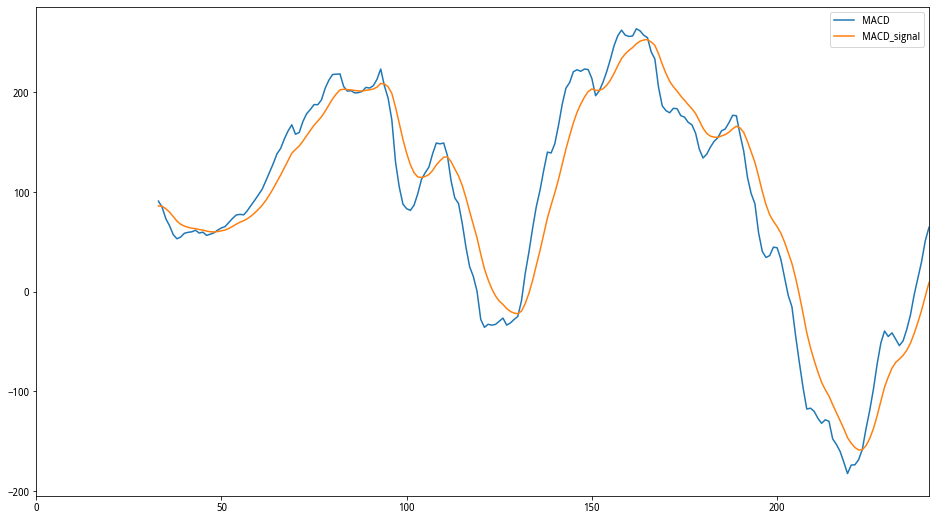

In [113]:
MACD_df.loc[MACD_df['tradeDate']<='2007-12-31',['MACD','MACD_signal']].plot()

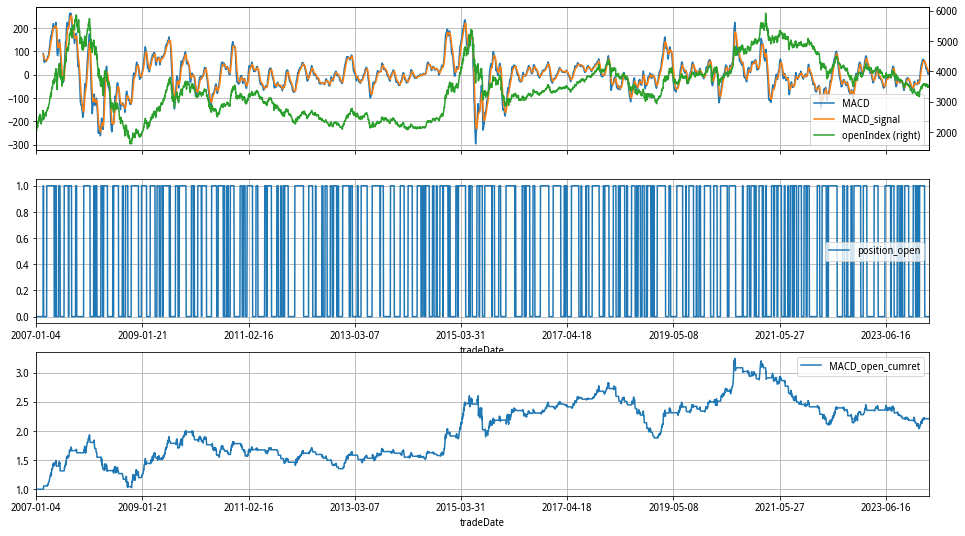

In [114]:
MACD_df['signal'] = 0
MACD_df.loc[MACD_df['MACD'] > MACD_df['MACD_signal'], 'signal'] = 1
MACD_df['open_ret'] = MACD_df['openIndex']/MACD_df['openIndex'].shift()-1
MACD_df['position_close'] = MACD_df['signal']
MACD_df['position_open'] = MACD_df['signal'].shift()
MACD_df.rename(columns={'CHGPct':'close_ret'},inplace=True)
MACD_df['position_close_ret'] = MACD_df['position_close'].shift() * MACD_df['close_ret']
MACD_df['position_open_ret'] = MACD_df['position_open'].shift() * MACD_df['open_ret']
MACD_df['position_close_ret_demean'] = MACD_df['position_close'].shift() * MACD_df['close_ret_demean']
MACD_df['position_open_ret_demean'] = MACD_df['position_open'].shift() * MACD_df['open_ret_demean']
MACD_df['MACD_close_cumret'] = (MACD_df['position_close_ret']+1).cumprod()
MACD_df['MACD_open_cumret'] = (MACD_df['position_open_ret']+1).cumprod()
MACD_ret_df = MACD_df[['tradeDate','openIndex','closeIndex','open_ret','close_ret','MACD','MACD_signal',
                        'signal','position_close','position_open','position_close_ret','position_open_ret',
                       'position_close_ret_demean','position_open_ret_demean',
                        'MACD_close_cumret','MACD_open_cumret']].copy()
MACD_ret_df.set_index('tradeDate',inplace=True)
# open price cumret
fig, axes = plt.subplots(3,1)
MACD_ret_df[['MACD','MACD_signal']].plot(ax=axes[0], grid=True)
MACD_ret_df[['openIndex']].plot(secondary_y=True,ax=axes[0],grid=True)
MACD_ret_df[['position_open']].plot(ax=axes[1], grid=True)
MACD_ret_df[['MACD_open_cumret']].plot(ax=axes[2], grid=True)

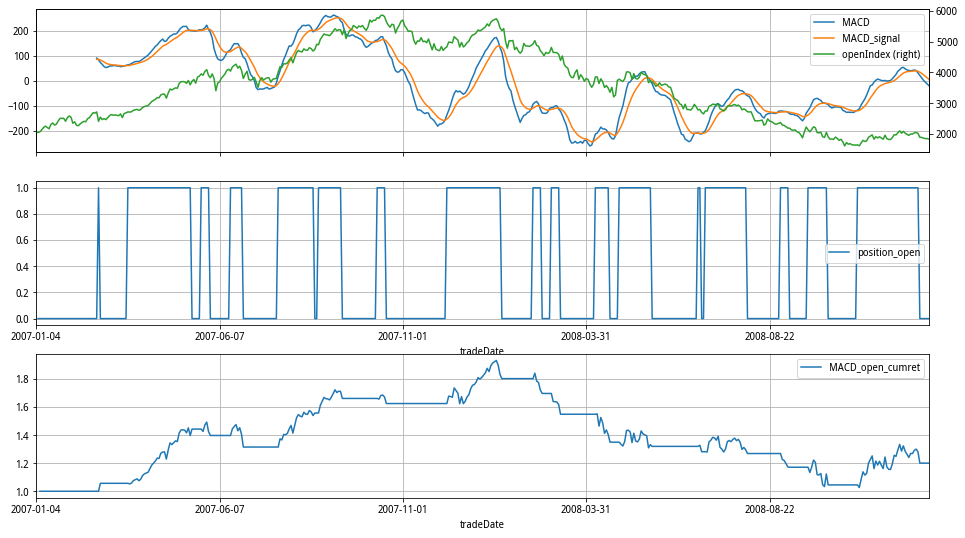

In [115]:
fig, axes = plt.subplots(3,1)
MACD_ret_df.loc[:'2009',['MACD','MACD_signal']].plot(ax=axes[0], grid=True)
MACD_ret_df.loc[:'2009',['openIndex']].plot(secondary_y=True,ax=axes[0],grid=True)
MACD_ret_df.loc[:'2009',['position_open']].plot(ax=axes[1], grid=True)
MACD_ret_df.loc[:'2009',['MACD_open_cumret']].plot(ax=axes[2], grid=True)

## Cross-sectional test

In [116]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,EMA,open_ret,close_ret,signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,1053.778,970.235,4.835036e+10,4.182345e+09,0.0840,NaN,NaN,0.197544,0
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,1085.740,988.906,5.318694e+10,2.285485e+09,0.0440,NaN,-0.016970,0.100033,0
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,1132.891,1069.601,5.487665e+10,2.761567e+09,0.0510,NaN,0.097410,0.031769,0
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,1157.574,1087.005,5.456661e+10,2.324186e+09,0.0426,NaN,0.011516,-0.005650,0
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,1069.284,1002.513,4.994705e+10,2.446556e+09,0.0489,NaN,-0.120245,-0.084659,0
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,1024.348,950.299,4.672266e+10,1.617434e+09,0.0336,NaN,-0.005682,-0.064557,0
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,948.717,861.377,4.266117e+10,1.410758e+09,0.0316,NaN,-0.053968,-0.086928,0
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,881.629,840.807,4.247515e+10,8.756147e+08,0.0209,NaN,-0.100336,-0.004360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12578732,689009.XSHG,2024-04-10,28.070,27.570,28.180,28.180,27.150,1.421167e+10,1.128337e+08,0.0080,29.920663,0.026594,-0.017813,0


In [117]:
stk_df.drop('EMA',axis=1,inplace=True)

In [118]:
stk_df['MACD'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[0])
stk_df['MACD_signal'] = stk_df.groupby('secID')['closePrice'].apply(lambda x: ta.MACD(x)[1])

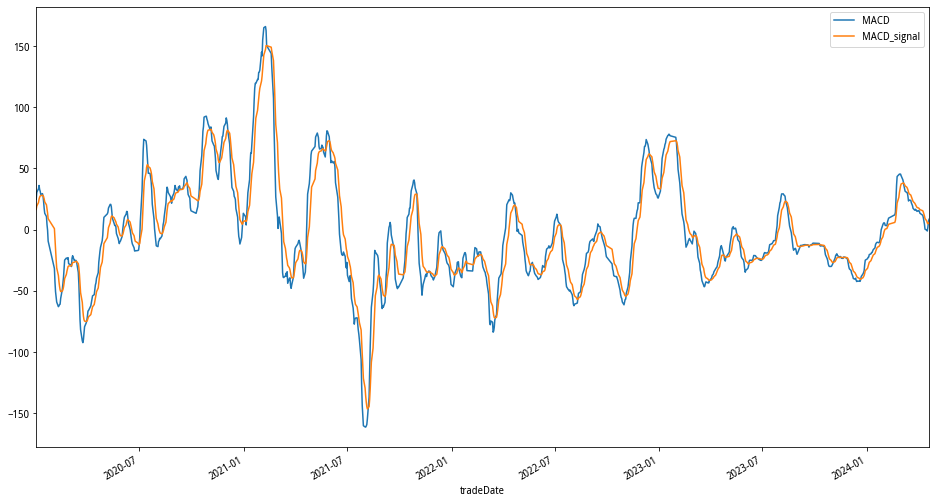

In [119]:
stk_df.loc[stk_df['secID']=='000001.XSHE',['tradeDate','MACD','MACD_signal']].set_index('tradeDate').loc['2020':].plot()

In [120]:
stk_df['signal'] = 0
stk_df.loc[stk_df['MACD'] > stk_df['MACD_signal'], 'signal'] = 1

In [121]:
stk_df

,secID,tradeDate,preClosePrice,closePrice,openPrice,highestPrice,lowestPrice,negMarketValue,turnoverValue,turnoverRate,open_ret,close_ret,signal,MACD,MACD_signal
109,000001.XSHE,2007-06-20,824.193,987.007,1044.285,1053.778,970.235,4.835036e+10,4.182345e+09,0.0840,NaN,0.197544,0,NaN,NaN
110,000001.XSHE,2007-06-21,987.007,1085.740,1026.564,1085.740,988.906,5.318694e+10,2.285485e+09,0.0440,-0.016970,0.100033,0,NaN,NaN
111,000001.XSHE,2007-06-22,1085.740,1120.233,1126.562,1132.891,1069.601,5.487665e+10,2.761567e+09,0.0510,0.097410,0.031769,0,NaN,NaN
112,000001.XSHE,2007-06-25,1120.233,1113.904,1139.536,1157.574,1087.005,5.456661e+10,2.324186e+09,0.0426,0.011516,-0.005650,0,NaN,NaN
114,000001.XSHE,2007-06-27,1113.904,1019.602,1002.513,1069.284,1002.513,4.994705e+10,2.446556e+09,0.0489,-0.120245,-0.084659,0,NaN,NaN
115,000001.XSHE,2007-06-28,1019.602,953.780,996.817,1024.348,950.299,4.672266e+10,1.617434e+09,0.0336,-0.005682,-0.064557,0,NaN,NaN
116,000001.XSHE,2007-06-29,953.780,870.870,943.021,948.717,861.377,4.266117e+10,1.410758e+09,0.0316,-0.053968,-0.086928,0,NaN,NaN
117,000001.XSHE,2007-07-02,870.870,867.073,848.402,881.629,840.807,4.247515e+10,8.756147e+08,0.0209,-0.100336,-0.004360,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12578732,689009.XSHG,2024-04-10,28.070,27.570,28.180,28.180,27.150,1.421167e+10,1.128337e+08,0.0080,0.026594,-0.017813,0,-0.495800,0.067497


In [122]:
%%time
rule_ret_df = stk_df.groupby('secID').apply(rule_return)

CPU times: user 45.9 s, sys: 1.17 s, total: 47 s
Wall time: 47 s


In [123]:
rule_ret_df.reset_index(inplace=True)

In [124]:
rule_ret_df.drop('level_1',axis=1,inplace=True)

In [125]:
rule_ret_df

,secID,tradeDate,position_open_ret_demean,open_cumret
0,000001.XSHE,2007-06-20,NaN,NaN
1,000001.XSHE,2007-06-21,NaN,NaN
2,000001.XSHE,2007-06-22,0.0,1.000000
3,000001.XSHE,2007-06-25,0.0,1.000000
4,000001.XSHE,2007-06-27,-0.0,1.000000
5,000001.XSHE,2007-06-28,-0.0,1.000000
6,000001.XSHE,2007-06-29,-0.0,1.000000
7,000001.XSHE,2007-07-02,-0.0,1.000000
...,...,...,...,...
11647107,689009.XSHG,2024-04-10,0.0,0.773591


### Cross-sectional test of cumulative return

In [126]:
rule_cumret_by_crs = rule_ret_df.groupby('secID')['open_cumret'].last()

In [127]:
rule_cumret_by_crs

secID
000001.XSHE     1.114993
000002.XSHE     2.294606
000004.XSHE     5.451040
000005.XSHE     2.925598
000006.XSHE     7.514906
000007.XSHE     2.538491
000008.XSHE     2.829294
000009.XSHE    17.588384
                 ...    
688789.XSHG     0.893267
688793.XSHG     0.463594
688798.XSHG     0.486045
688799.XSHG     0.820711
688800.XSHG     0.377908
688819.XSHG     0.725053
688981.XSHG     0.708889
689009.XSHG     0.773591
Name: open_cumret, Length: 5299, dtype: float64

In [128]:
rule_cumret_by_crs.describe()

count    5299.000000
mean        1.927220
std         2.675874
min         0.010465
25%         0.707447
50%         1.083236
75%         2.025365
max        49.514932
Name: open_cumret, dtype: float64

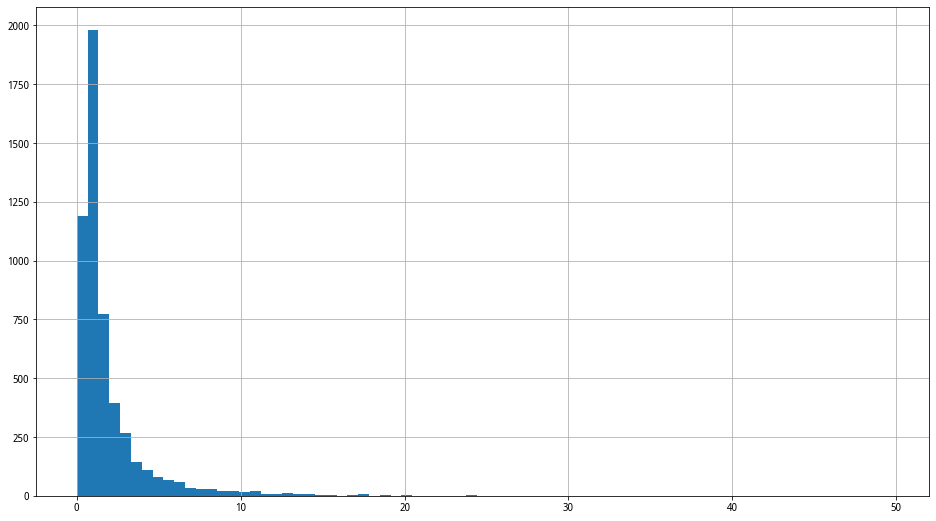

In [129]:
rule_cumret_by_crs.hist(bins=75)

In [130]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y-const, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_cumret'])

,rule_cumret
ret_mean,0.927220
t_values,25.226376


In [131]:
rule_cumret_by_crs.dropna(inplace=True)
y = rule_cumret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit()
print(reg.t_test('const = 1'))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.9272      0.037     25.224      0.000       1.855       1.999


平均年化收益：

In [132]:
# 2.1293**(1/(2022-2007+1))-1

0.04837052777619055

In [133]:
1.9272**(1/(2023-2007+1)) - 1

0.03934659891056258

### Cross-sectional test of mean daily return

In [134]:
# time-series mean of daily return
rule_tsmean_ret_by_crs = rule_ret_df.groupby('secID')['position_open_ret_demean'].mean()
rule_tsmean_ret_by_crs

secID
000001.XSHE   -0.000027
000002.XSHE    0.000145
000004.XSHE    0.000692
000005.XSHE    0.000507
000006.XSHE    0.000414
000007.XSHE    0.000229
000008.XSHE    0.000188
000009.XSHE    0.000643
                 ...   
688789.XSHG   -0.000248
688793.XSHG   -0.000248
688798.XSHG   -0.000283
688799.XSHG   -0.000184
688800.XSHG   -0.001112
688819.XSHG    0.000153
688981.XSHG    0.000045
689009.XSHG   -0.000296
Name: position_open_ret_demean, Length: 5299, dtype: float64

In [135]:
rule_tsmean_ret_by_crs.dropna(inplace=True)
y = rule_tsmean_ret_by_crs.values
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HC0')
mean_values = reg.params[0]
t_values = reg.tvalues[0]

In [136]:
pd.DataFrame([mean_values,t_values],index=['ret_mean','t_values'],columns=['rule_daily_ret'])

,rule_daily_ret
ret_mean,0.000041
t_values,5.323517


## Time series test. Bootstrapping: White's Reality Check

- 原始index return去掉均值的目的：过滤掉牛市或者熊市时，随机策略的正或负的收益的偏误
- position return 去掉均值的目的：bootstrap 的原假设是：策略期望收益是0。以此生成抽样分布。

In [137]:
rule_ret_series = MACD_ret_df['position_open_ret_demean'].dropna() # position_open_ret_demean: (raw return demeaned)*position
rule_ret_series_for_bootstrap = rule_ret_series - rule_ret_series.mean() # demean here: H0: the average of the rule's return is zero
n_sample = rule_ret_series.shape[0]
n_boostrap = 1000

In [138]:
n_sample

4202

In [139]:
rule_ret_series.mean()

0.00010860179949022546

In [140]:
rule_ret_mean_distr = []
for i in range(n_boostrap):
    rule_ret_mean_distr.append(np.random.choice(rule_ret_series_for_bootstrap, n_sample).mean())

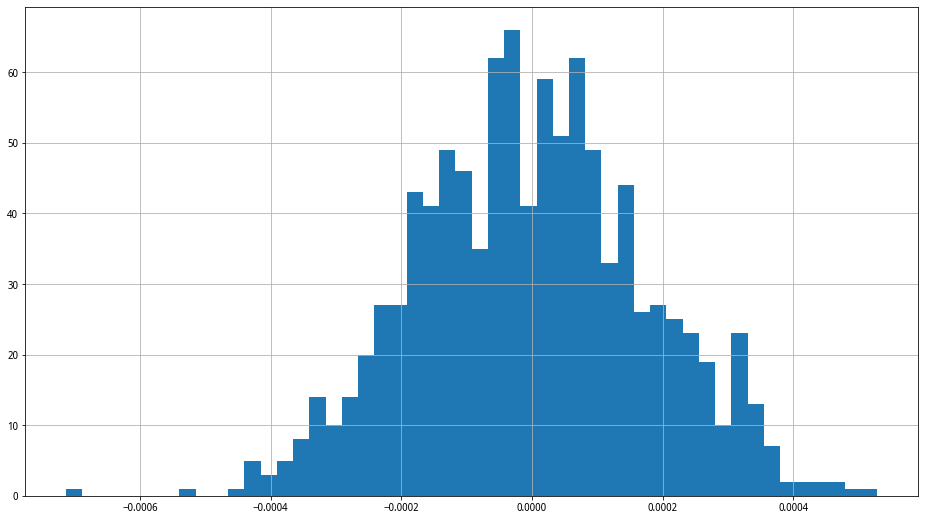

In [141]:
rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
rule_ret_mean_distr.hist(bins=50)

In [142]:
(rule_ret_mean_distr > rule_ret_series.mean()).sum() / n_boostrap

0.259

In [143]:
np.mean(rule_ret_series)

0.00010860179949022546

In [144]:
def white_reality_test(rule_ret, n_boostrap=1000):
    n_sample = len(rule_ret)
    if n_sample < 100:
        return None
    else:
        mean_rule_ret = np.mean(rule_ret)
        rule_ret_for_bootstrap = rule_ret - mean_rule_ret
        rule_ret_mean_distr = []
        for i in range(n_boostrap):
            rule_ret_mean_distr.append(np.random.choice(rule_ret_for_bootstrap, n_sample).mean())
        rule_ret_mean_distr = pd.Series(rule_ret_mean_distr)
        pvalue = (rule_ret_mean_distr > mean_rule_ret).sum() / n_boostrap
        return pvalue

In [145]:
# The p value of the rule's return series
white_reality_test(rule_ret_series)

0.258

#### Test another stock

In [146]:
one_stk_id = np.random.choice(rule_ret_df['secID'].unique(),1)[0]

In [147]:
rule_ret_series = rule_ret_df.loc[rule_ret_df['secID'] == one_stk_id,'position_open_ret_demean']

In [148]:
rule_ret_series.dropna(inplace=True)

In [149]:
white_reality_test(rule_ret_series)

0.182

#### Test 300 stocks

In [150]:
stk_id_300 = np.random.choice(rule_ret_df['secID'].unique(),300,replace=False)

In [151]:
temp = rule_ret_df.loc[rule_ret_df['secID'].isin(stk_id_300)].copy()

In [152]:
temp.dropna(inplace=True)

In [153]:
temp

,secID,tradeDate,position_open_ret_demean,open_cumret
25651,000010.XSHE,2013-10-22,0.000000,1.000000
25652,000010.XSHE,2013-10-23,0.000000,1.000000
25653,000010.XSHE,2013-10-24,-0.000000,1.000000
25654,000010.XSHE,2013-10-25,0.000000,1.000000
25655,000010.XSHE,2013-10-28,-0.000000,1.000000
25656,000010.XSHE,2013-10-29,-0.000000,1.000000
25657,000010.XSHE,2013-10-30,-0.000000,1.000000
25658,000010.XSHE,2013-10-31,0.000000,1.000000
...,...,...,...,...
11643897,688799.XSHG,2024-04-10,0.009726,0.849062


In [154]:
%%time
stk_white_p = temp.groupby('secID')['position_open_ret_demean'].apply(white_reality_test)

CPU times: user 36.4 s, sys: 16 ms, total: 36.4 s
Wall time: 36.4 s


In [155]:
stk_white_p

secID
000010.XSHE    0.459
000034.XSHE    0.625
000042.XSHE    0.378
000066.XSHE    0.062
000525.XSHE    0.638
000528.XSHE    0.233
000537.XSHE    0.140
000548.XSHE    0.315
               ...  
688623.XSHG    0.527
688630.XSHG    0.450
688638.XSHG    0.196
688668.XSHG    0.387
688700.XSHG    0.524
688776.XSHG    0.659
688777.XSHG    0.557
688799.XSHG    0.614
Name: position_open_ret_demean, Length: 300, dtype: float64

In [156]:
stk_white_p.describe()

count    297.000000
mean       0.490135
std        0.242505
min        0.044000
25%        0.289000
50%        0.480000
75%        0.684000
max        0.988000
Name: position_open_ret_demean, dtype: float64

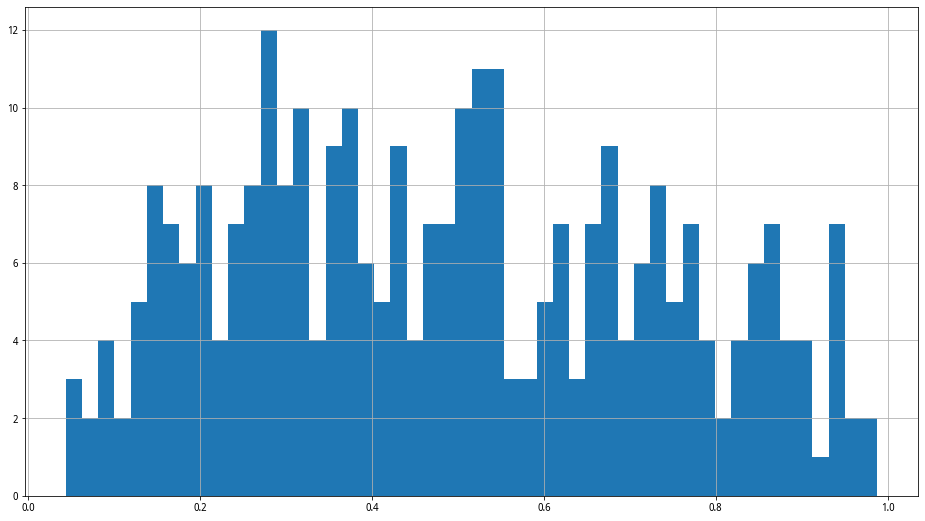

In [157]:
stk_white_p.hist(bins=50)

In [158]:
stk_white_p.loc[stk_white_p < 0.10]

secID
000066.XSHE    0.062
000566.XSHE    0.088
000670.XSHE    0.093
002232.XSHE    0.094
002499.XSHE    0.046
002610.XSHE    0.083
300312.XSHE    0.070
600701.XSHG    0.081
601222.XSHG    0.044
Name: position_open_ret_demean, dtype: float64

In [159]:
good_MACD_stks = stk_white_p.loc[stk_white_p < 0.10].index

In [160]:
rule_ret_df.loc[rule_ret_df['secID']=='301296.XSHE','open_cumret']

6637805         NaN
6637806         NaN
6637807    1.000000
6637808    1.000000
6637809    1.000000
6637810    1.000000
6637811    1.000000
6637812    1.000000
             ...   
6638190    0.845012
6638191    0.813486
6638192    0.813486
6638193    0.780111
6638194    0.780111
6638195    0.780111
6638196    0.780111
6638197    0.780111
Name: open_cumret, Length: 393, dtype: float64

In [161]:
rule_ret_df.loc[rule_ret_df['secID'].isin(good_MACD_stks[0:5])].set_index('tradeDate',inplace=True)

In [162]:
temp2 = rule_ret_df.loc[rule_ret_df['secID'].isin(good_MACD_stks)].copy()

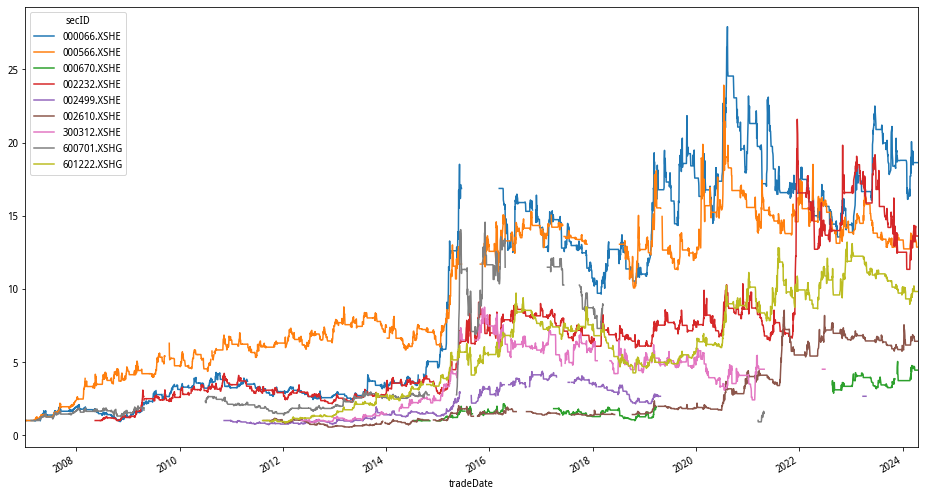

In [163]:
temp2.pivot(index='tradeDate',columns='secID',values='open_cumret').plot()

# White's Reality Check for multiple strategies

In [164]:
def rule_return_open(df, demean=True):
    """
    df should contain these columns:
        signal: the signal generated by the rule
        close_ret: return calculated by close price
        open_ret: return calculated by open price
    close_ret_demean is demeaned return of close_ret, i.e. close_ret - close_ret.mean.
    open_ret_demean is similarly defined. The use of demeaned return series is to adjust the
    bias created by bullish or bearish markets.
    """
    df['position_open'] = df['signal'].shift()
    df['position_open_ret'] = df['position_open'].shift() * df['open_ret']
    df['position_open_ret_demean'] = df['position_open'].shift() * df['open_ret_demean']
    if demean==True:
        return df['position_open_ret_demean']
    else:
        return df['position_open_ret']

In [165]:
cols = ['tradeDate','openIndex','closeIndex','open_ret','close_ret','open_ret_demean','close_ret_demean']
ta_rules_df = hs300_df[cols].copy()

In [166]:
# MA
ma_params = [30, 20, 10]
for ma_param in ma_params:
    ta_rules_df[f'MA{ma_param}'] = ta.SMA(ta_rules_df['closeIndex'], ma_param)
    ta_rules_df['signal'] = np.nan
    ta_rules_df.loc[ta_rules_df['closeIndex'] > ta_rules_df[f'MA{ma_param}'], 'signal'] = 1
    ta_rules_df.loc[ta_rules_df['closeIndex'] < ta_rules_df[f'MA{ma_param}'], 'signal'] = 0
    ta_rules_df[f'ret_MA{ma_param}'] = rule_return_open(ta_rules_df)
    
ta_rules_df = ta_rules_df[cols+[f'ret_MA{ma_param}' for ma_param in ma_params]].copy()

In [167]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10
0,2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0.012491,NaN,NaN,NaN
1,2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,-0.010946,0.002534,NaN,NaN,NaN
2,2007-01-08,2072.0000,2131.5600,0.010165,0.028308,0.009878,0.028041,NaN,NaN,NaN
3,2007-01-09,2137.4900,2200.0900,0.031607,0.032150,0.031320,0.031883,NaN,NaN,NaN
4,2007-01-10,2210.7600,2255.9700,0.034279,0.025399,0.033992,0.025132,NaN,NaN,NaN
5,2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,0.020634,-0.011056,NaN,NaN,NaN
6,2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,-0.018519,-0.026203,NaN,NaN,NaN
7,2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,-0.020559,0.051988,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4196,2024-04-10,3528.9679,3504.7086,-0.001250,-0.008145,-0.001537,-0.008412,-0.000000,-0.000000,-0.000000


In [168]:
cols = ta_rules_df.columns.tolist()

In [169]:
#EMA
ema_params = [30, 20, 10]
for ema_param in ema_params:
    ta_rules_df[f'EMA{ema_param}'] = ta.EMA(ta_rules_df['closeIndex'], ema_param)
    ta_rules_df['signal'] = np.nan
    ta_rules_df.loc[ta_rules_df['closeIndex'] > ta_rules_df[f'EMA{ema_param}'], 'signal'] = 1
    ta_rules_df.loc[ta_rules_df['closeIndex'] < ta_rules_df[f'EMA{ema_param}'], 'signal'] = 0
    ta_rules_df[f'ret_EMA{ema_param}'] = rule_return_open(ta_rules_df)
    
ta_rules_df = ta_rules_df[cols+[f'ret_EMA{ema_param}' for ema_param in ema_params]].copy()

In [170]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10,ret_EMA30,ret_EMA20,ret_EMA10
0,2007-01-04,2073.2500,2067.0900,NaN,0.012758,NaN,0.012491,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-01-05,2051.1500,2072.8800,-0.010660,0.002801,-0.010946,0.002534,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-01-08,2072.0000,2131.5600,0.010165,0.028308,0.009878,0.028041,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-01-09,2137.4900,2200.0900,0.031607,0.032150,0.031320,0.031883,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-01-10,2210.7600,2255.9700,0.034279,0.025399,0.033992,0.025132,NaN,NaN,NaN,NaN,NaN,NaN
5,2007-01-11,2257.0100,2231.6300,0.020920,-0.010789,0.020634,-0.011056,NaN,NaN,NaN,NaN,NaN,NaN
6,2007-01-12,2215.8600,2173.7500,-0.018232,-0.025936,-0.018519,-0.026203,NaN,NaN,NaN,NaN,NaN,NaN
7,2007-01-15,2170.9400,2287.3400,-0.020272,0.052255,-0.020559,0.051988,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,2024-04-10,3528.9679,3504.7086,-0.001250,-0.008145,-0.001537,-0.008412,-0.000000,-0.000000,-0.000000,-0.001537,-0.000000,-0.000000


In [171]:
cols = ta_rules_df.columns.tolist()

In [172]:
# MACD
macd_models = {'MACD1': {'fastperiod':12, 'slowperiod':26, 'signalperiod':9},
               'MACD2': {'fastperiod':10, 'slowperiod':20, 'signalperiod':5}}
for macd, param in macd_models.items():
    ta_rules_df[macd], ta_rules_df[f'{macd}_signal'], _ = ta.MACD(ta_rules_df['closeIndex'], fastperiod=param['fastperiod'], slowperiod=param['slowperiod'], signalperiod=param['signalperiod'])
    ta_rules_df['signal'] = 0
    ta_rules_df.loc[ta_rules_df[macd] > ta_rules_df[f'{macd}_signal'], 'signal'] = 1
    ta_rules_df[f'ret_{macd}'] = rule_return_open(ta_rules_df)

In [173]:
ta_rules_df.dropna(inplace=True)
ta_rules_df.reset_index(inplace=True,drop=True)

In [174]:
ta_rules_df

,tradeDate,openIndex,closeIndex,open_ret,close_ret,open_ret_demean,close_ret_demean,ret_MA30,ret_MA20,ret_MA10,...,MACD1,MACD1_signal,signal,position_open,position_open_ret,position_open_ret_demean,ret_MACD1,MACD2,MACD2_signal,ret_MACD2
0,2007-02-27,2717.8100,2457.4900,0.014385,-0.092400,0.014098,-0.092667,0.014098,0.014098,0.014098,...,90.911597,86.028313,0,1.0,0.014385,0.014098,0.000000,71.690413,73.792501,0.014098
1,2007-02-28,2413.4200,2544.5700,-0.111998,0.035435,-0.112285,0.035168,-0.112285,-0.112285,-0.112285,...,84.683369,85.759325,0,0.0,-0.111998,-0.112285,-0.000000,65.064530,70.883178,-0.112285
2,2007-03-01,2550.2600,2473.5400,0.056700,-0.027914,0.056413,-0.028181,0.056413,0.000000,0.000000,...,73.172441,83.241948,0,0.0,0.000000,0.000000,0.056413,52.883214,64.883190,0.000000
3,2007-03-02,2468.6700,2508.7300,-0.031993,0.014227,-0.032280,0.013960,-0.032280,-0.032280,-0.000000,...,66.127212,79.819001,0,0.0,-0.000000,-0.000000,-0.000000,45.996903,58.587761,-0.000000
4,2007-03-05,2503.8200,2475.6100,0.014238,-0.013202,0.013952,-0.013469,0.013952,0.000000,0.000000,...,57.211809,75.297562,0,0.0,0.000000,0.000000,0.000000,37.235228,51.470250,0.000000
5,2007-03-06,2467.7400,2520.2900,-0.014410,0.018048,-0.014697,0.017781,-0.014697,-0.014697,-0.000000,...,53.139036,70.865857,0,0.0,-0.000000,-0.000000,-0.000000,33.972945,45.637815,-0.000000
6,2007-03-07,2532.9800,2589.4400,0.026437,0.027437,0.026150,0.027170,0.026150,0.026150,0.000000,...,54.858783,67.664442,0,0.0,0.000000,0.000000,0.000000,36.956746,42.744125,0.000000
7,2007-03-08,2597.7200,2627.6300,0.025559,0.014748,0.025272,0.014481,0.025272,0.025272,0.000000,...,58.627488,65.857051,0,0.0,0.000000,0.000000,0.000000,41.832083,42.440111,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,2024-04-10,3528.9679,3504.7086,-0.001250,-0.008145,-0.001537,-0.008412,-0.000000,-0.000000,-0.000000,...,13.893066,25.101163,0,0.0,-0.000000,-0.000000,-0.000000,3.496673,9.118013,-0.000000


In [175]:
multi_rule_cols = ta_rules_df.columns[ta_rules_df.columns.str.startswith('ret')]

multi_rule_ret_df = ta_rules_df[multi_rule_cols].copy()

multi_rule_ret_df

,ret_MA30,ret_MA20,ret_MA10,ret_EMA30,ret_EMA20,ret_EMA10,ret_MACD1,ret_MACD2
0,0.014098,0.014098,0.014098,0.014098,0.014098,0.014098,0.000000,0.014098
1,-0.112285,-0.112285,-0.112285,-0.112285,-0.112285,-0.112285,-0.000000,-0.112285
2,0.056413,0.000000,0.000000,0.056413,0.000000,0.000000,0.056413,0.000000
3,-0.032280,-0.032280,-0.000000,-0.032280,-0.032280,-0.032280,-0.000000,-0.000000
4,0.013952,0.000000,0.000000,0.013952,0.000000,0.000000,0.000000,0.000000
5,-0.014697,-0.014697,-0.000000,-0.014697,-0.014697,-0.000000,-0.000000,-0.000000
6,0.026150,0.026150,0.000000,0.026150,0.000000,0.000000,0.000000,0.000000
7,0.025272,0.025272,0.000000,0.025272,0.025272,0.025272,0.000000,0.000000
...,...,...,...,...,...,...,...,...
4163,-0.000000,-0.000000,-0.000000,-0.001537,-0.000000,-0.000000,-0.000000,-0.000000


In [176]:
def multi_white_reality_test(target_rule, multi_rule_ret_df, n_bootstrap=500):
    """
    target_rule: the name of the rule under consideration. target_rule should be one column of multi_rule_ret_df.
    multi_rule_ret_df: the df of multiple rule returns.
    """
    n_sample = multi_rule_ret_df.shape[0]
    if n_sample < 100:
        return None
    else:   
        max_bs_distr = np.full(shape=n_bootstrap, fill_value=np.nan)
        multi_rule_ret_df_mean = multi_rule_ret_df - multi_rule_ret_df.mean()
        for i in tqdm(range(n_bootstrap)):
            idx = np.random.choice(multi_rule_ret_df.index, n_sample)
            max_bs_distr[i] = multi_rule_ret_df_mean.loc[idx].mean().max()
        pvalue = (max_bs_distr > multi_rule_ret_df[target_rule].mean()).sum() / n_bootstrap
        return pvalue, max_bs_distr

In [177]:
p_MACD1, max_bs_distr_MACD1 = multi_white_reality_test(target_rule='ret_MACD1', multi_rule_ret_df=multi_rule_ret_df)

100%|██████████| 500/500 [00:00<00:00, 679.92it/s]


In [178]:
p_MACD1

0.526

Compare this with the WRC when there is only one 